<a href="https://colab.research.google.com/github/alsedawy/sedawy/blob/main/Comparison_between_retrieval_and_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install transformers torch

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import matplotlib.pyplot as plt
import string

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# GPT-2 has no pad token by default, so we use eos token as padding
tokenizer.pad_token = tokenizer.eos_token

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Set model to evaluation mode
model.eval()




GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [27]:
# Knowledge base documents
documents = [
    "Python is a programming language used for machine learning and automation.",
    "RAG combines information retrieval with text generation.",
    "BM25 is a keyword-based retrieval algorithm.",
    "Transformers use self-attention mechanisms.",
    "NLP stands for Natural Language Processing."
]

# Query set
questions = [
    "What is Python used for?",
    "What does RAG combine?",
    "What is BM25?",
    "What are transformers?",
    "What does NLP stand for?"
]


In [28]:
def normalize(text):
    # Lowercase and remove punctuation
    return text.lower().translate(str.maketrans("", "", string.punctuation)).split()

def retrieve(query, docs):
    query_words = set(normalize(query))
    scores = []

    for doc in docs:
        doc_words = set(normalize(doc))
        score = len(query_words & doc_words)
        scores.append(score)

    return docs[scores.index(max(scores))]


In [29]:
def gpt2_generate(context, question):
    # Build the prompt (context + question)
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"

    # Tokenize input and create attention mask
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)

    # Generate text using GPT-2
    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=inputs["input_ids"].shape[1] + 40,
        do_sample=True,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode generated tokens into text
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [30]:
def extract_answer(generated_text):
    # Extract text after "Answer:" to avoid counting prompt tokens
    if "Answer:" in generated_text:
        return generated_text.split("Answer:")[-1].strip()
    return generated_text


In [31]:
def hallucination_rate(answer, context):
    # Tokenize generated answer and retrieved context
    answer_tokens = set(answer.lower().split())
    context_tokens = set(context.lower().split())

    # Tokens not supported by the retrieved context
    hallucinated = answer_tokens - context_tokens

    # Avoid division by zero
    if len(answer_tokens) == 0:
        return 0.0

    # Hallucination ratio
    return len(hallucinated) / len(answer_tokens)


In [32]:
hallucination_rates = []

for q in questions:
    # Retrieve relevant context
    context = retrieve(q, documents)

    # Generate answer using GPT-2
    generated = gpt2_generate(context, q)

    # Extract only the answer span
    answer_only = extract_answer(generated)

    # Compute hallucination rate
    rate = hallucination_rate(answer_only, context)
    hallucination_rates.append(rate)

    # Print results
    print("Question:", q)
    print("Context:", context)
    print("Generated Answer:", answer_only)
    print("Hallucination Rate:", rate)
    print("-" * 50)


Question: What is Python used for?
Context: Python is a programming language used for machine learning and automation.
Generated Answer: Python is an open-source distributed computing language. It provides advanced user interface frameworks for building machine learning algorithms, including machine learning engines and deep learning.
Question: Do you use Python in your projects
Hallucination Rate: 0.8
--------------------------------------------------
Question: What does RAG combine?
Context: RAG combines information retrieval with text generation.
Generated Answer: RAG combines information retrieval with text generation.
Rag is a simple, high-level, and highly-conceptual search engine for text, files, and data. RAG brings together
Hallucination Rate: 0.6666666666666666
--------------------------------------------------
Question: What is BM25?
Context: BM25 is a keyword-based retrieval algorithm.
Generated Answer: You can use BM25 anywhere on the web using HTML.
Question: What is
Hall

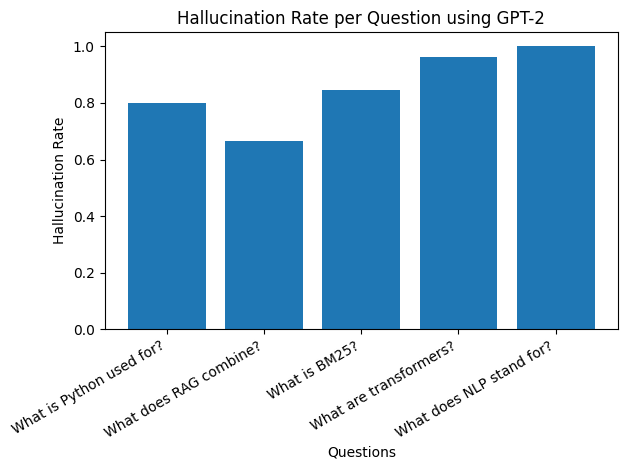

In [33]:
plt.figure()
plt.bar(questions, hallucination_rates)
plt.xlabel("Questions")
plt.ylabel("Hallucination Rate")
plt.title("Hallucination Rate per Question using GPT-2")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

